In [1]:
from pprint import pprint
from datetime import datetime
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from utils import *

In [ ]:
# PLOT PROPORTION OF TIME IN FAILURE FOR ALL PARTICIPANTS
data = load_nested_dict('data/Processed') 
alpha = 0.5
prop_scale = 3
total_color = "black"

fig, axes = plt.subplots(ncols=len(data.items()), nrows=4, figsize=(17,8))

for (participant, _data1), _axes in zip(data.items(), axes.T):
    for (experiment, _data2), ax in zip(_data1.items(), _axes):
        ax.axis('off'), ax.set_ylim(0, prop_scale)
        start_time, finish_time =  _data2['start_time'], _data2['finish_time']
        failure_proportions, all_failure_intervals = [], []
        for task, _data3 in _data2['tasks'].items():
            failure_intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
            failure_intervals = merge_intervals(failure_intervals) # merge them to get failures for a single task
            failure_proportion = Statistics.compute_failure_proportion(failure_intervals, start_time, finish_time)
            ax.bar(0, failure_proportion, bottom=sum(failure_proportions), width=1, align='center', alpha=alpha, color=ALL_WINDOW_PROPERTIES[task]['color'])
            failure_proportions.append(failure_proportion)
            all_failure_intervals.append(failure_intervals)
        ax.bar(0, prop_scale-sum(failure_proportions), bottom=sum(failure_proportions), width=1, align='center', alpha=0.05,color='black')
    
        total_failure = merge_intervals(all_failure_intervals) # overlapping total
        total_failure_proportion = Statistics.compute_failure_proportion(total_failure, start_time, finish_time)
        ax.axhline(y=total_failure_proportion, color=total_color, alpha=alpha)

                 
for ax, par in zip(axes[0,:], data.keys()):
    ax.set_title(par)
for ax, par in zip(axes[:,0], data['P01'].keys()):
    ax.text(-1, 1.4, par[3:], rotation='vertical', size='large')
for k,v in ALL_WINDOW_PROPERTIES.items():
    plt.gca().scatter([],[], label=k, color=v['color'], alpha=alpha) # for legend purposes
plt.gca().plot([],[], label='total', color=total_color, alpha=alpha) 
plt.legend(loc=(-13,-0.3), ncols=len(ALL_WINDOW_PROPERTIES)+1)
fig.suptitle("Failure Proportion", size=16)

Text(0.5, 0.6, 'Failure Count')

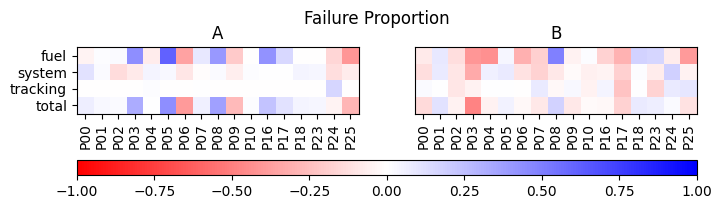

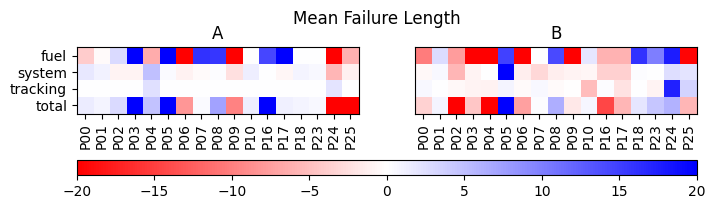

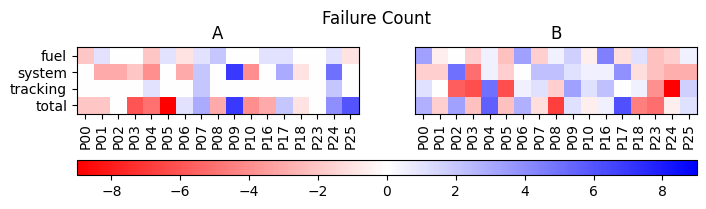

In [15]:
# PLOT DIFFERENCE PERFORMANCE METRICS
data = load_nested_dict('data/Processed') 

def compute_failure_interval_statistics(data, statistic):
    df = pd.DataFrame(columns=['participant', 'experiment', *sorted(ALL_WINDOW_PROPERTIES.keys()), 'total'])
    for participant, _data1 in data.items():
        for experiment, _data2 in _data1.items():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            stats, all_failure_intervals = [], []
            for task, _data3 in sorted(_data2['tasks'].items()):
                failure_intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
                failure_intervals = merge_intervals(failure_intervals) # merge them to get failures for a single task
                stats.append(statistic(failure_intervals, start_time, finish_time))
                all_failure_intervals.append(failure_intervals)
            total_failure = merge_intervals(all_failure_intervals) # overlapping total
            total_stat = statistic(total_failure, start_time, finish_time)
            df.loc[len(df)] = [participant, experiment[3:], *stats, total_stat]
    return df

def plot_performance(df, rnd=False, vmin=-1, vmax=1):
    grouped = df.select_dtypes(include=['float','integer']).groupby(df['experiment'])
    data = {name:group.values for name,group in grouped}
    use_vs = not (vmin is None and vmax is None)
    
    def _plot(k1, k2, ax, showbar=False):
        dif = (data[k2].astype(np.float64) - data[k1].astype(np.float64)) # icua should have a LOWER failure proportion.
        indx = (np.where(dif < 0, -1, np.where(dif > 0, 1, 0))).astype(int) if rnd else dif    
        cmap = matplotlib.colormaps.get_cmap("bwr").reversed()
        _vmin, _vmax = vmin, vmax
        if not use_vs:
            _vmax, _vmin = dif.max(), dif.min()
            _v = max(abs(_vmin), _vmax)
            _vmin, _vmax = -_v, _v
        return ax.imshow(indx.T, cmap=cmap, vmin=_vmin, vmax=_vmax)

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    axA, axB = axes.ravel()
    
    imA = _plot('icuaA', 'icuA', axA)
    imB = _plot('icuaB', 'icuB', axB, showbar=True)
    axA.set_yticks(np.arange(len(df.columns[2:])), df.columns[2:])
    pars = df['participant'].unique()
    axA.set_xticks(np.arange(len(pars)), pars, rotation=90)
    axA.set_title("A")
    
    axB.tick_params(axis='both', which='both',top=False,left=False,right=False)
    axB.set_yticks([],[])
    axB.set_xticks(np.arange(len(pars)), pars, rotation=90)
    plt.colorbar(imA, ax=[axB, axA], aspect = 40, location="bottom") ##Common colobar for ax1 and ax2; aspect used to set colorbar thickness/width
    axB.set_title("B")
    return fig
       

# proportion of time spent in failure
failure_proportions = compute_failure_interval_statistics(data, Statistics.compute_failure_proportion)
fig = plot_performance(failure_proportions, vmin=-1, vmax=1)
fig.suptitle("Failure Proportion",y=0.6,x=0.5)

# mean length of each failure interval
mean_failure_length = compute_failure_interval_statistics(data, Statistics.compute_mean_interval_length)
#print(mean_failure_length)
fig = plot_performance(mean_failure_length, vmin=-20, vmax=20)
fig.suptitle("Mean Failure Length", y=0.6,x=0.5)

# number of times a failure occured
failure_count = compute_failure_interval_statistics(data, Statistics.compute_failure_count)
#print(failure_count)
fig = plot_performance(failure_count, vmin=None, vmax=None)
fig.suptitle("Failure Count", y=0.6,x=0.5)



In [ ]:
data = load_nested_dict('data/Processed') 

df = pd.DataFrame(columns=['participant', 'experiment', *sorted(ALL_WINDOW_PROPERTIES.keys()), 'total'])
for participant, _data1 in data.items():
    for experiment, _data2 in _data1.items():
        start_time, finish_time =  _data2['start_time'], _data2['finish_time']
        failure_proportions, all_failure_intervals = [], []
        for task, _data3 in sorted(_data2['tasks'].items()):
            failure_intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
            failure_intervals = merge_intervals(failure_intervals) # merge them to get failures for a single task
            failure_proportion = Statistics.compute_failure_proportion([failure_intervals], start_time, finish_time)
            failure_proportions.append(failure_proportion)
            all_failure_intervals.append(failure_intervals)
        total_failure = merge_intervals(all_failure_intervals) # overlapping total
        total_failure_proportion = Statistics.compute_failure_proportion([total_failure], start_time, finish_time)
        df.loc[len(df)] = [participant, experiment[3:], *failure_proportions, total_failure_proportion]
        
def plot_mean(df, groupby, total_color = "black"):
    data = df.select_dtypes(include='float').groupby(groupby)
    fig, axes = plt.subplots(ncols=len(data), nrows=1, figsize=(len(data),2))
    fig.suptitle("Mean Failure Proportion", y=1)
    _axes = iter(axes.ravel())
    for (indx, mu), (_, sigma) in zip(data.mean().iterrows(), data.std().iterrows()):
        ax = next(_axes)
        ax.axis('off')
        prop_scale = 3
        ax.set_ylim(0,prop_scale) 
        for i, (k, v) in enumerate(zip(mu.keys()[:-1], mu.values[:-1])):
            ax.bar(0, v, bottom=sum(mu.values[:i]), width=1, align='center', alpha=alpha, color=ALL_WINDOW_PROPERTIES[k]['color'])
        ax.bar(0, prop_scale-sum(mu.values[:-1]), bottom=sum(mu.values[:-1]), width=1, align='center', alpha=0.05,color='black')
        ax.axhline(y=mu.values[-1], color=total_color, alpha=alpha)
        ax.set_title(indx,y=-0.2)

def plot_differences(df, groupby, alpha=1):
    grouped = df.select_dtypes(include='float').groupby(groupby)
    data = {name:group.values for name,group in grouped}
    # if this is negative, the agents did bad.
    difA = data['icuA'] - data['icuaA'] # icua should have a LOWER failure proportion.
    difB = data['icuB'] - data['icuaB'] # icua should have a LOWER failure proportion.

    fig, axes = plt.subplots(ncols=len(difA), nrows=2, figsize=(len(difA)/2,4), sharey=True)
    #fig.suptitle("Differences")
    ylima = max(abs(np.min(difA)), abs(np.max(difA)))
    ylimb = max(abs(np.min(difB)), abs(np.max(difB)))
    for (A,B,(axa, axb)) in zip(difA, difB, axes.T):
        axa.set_xticklabels([]),  axb.set_xticklabels([])
        axa.tick_params(axis='both', which='both', bottom=False, top=False,left=False,right=False)
        axb.tick_params(axis='both', which='both', bottom=False, top=False,left=False,right=False)
        prop_scale = 3
        axa.set_ylim(-ylima, ylima), axb.set_ylim(-ylimb, ylimb)
        
        #axa.set_ylim(0,prop_scale), axb.set_ylim(0,prop_scale) 
        for i,(k, a, b) in enumerate(zip(df.select_dtypes(include='float').columns[:-1], A[:-1],B[:-1])):
            axa.axhline(y=a, color=ALL_WINDOW_PROPERTIES[k]['color'], alpha=alpha)
            axb.axhline(y=b, color=ALL_WINDOW_PROPERTIES[k]['color'], alpha=alpha)
    axes[0,0].tick_params(left=True)
    axes[1,0].tick_params(left=True)
    axes[0,axes.shape[1]//2].text(-1.4,-0.62,"Differences A (Easy)")
    axes[1,axes.shape[1]//2].text(-1.4,-0.62,"Differences B (Hard)")
    for ax, par in zip(axes[0], df['participant'].unique()):
        ax.set_title(par, size="medium")  
        
#plot_differences(df, df['experiment'])

# MEAN OF FAILURE PROPORTIONS
plot_mean(df, df['experiment'])
plot_mean(df, df['participant'])




In [ ]:
df = get_demographics_data()
df = df[df['participant'].isin(data.keys())]
for column in df.columns[1:]:
    value_counts = df[column].value_counts()
    print(value_counts)